In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

def process(df):
    # This is where you can do all your processing

#     df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
#     df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)

#     # Perform TF-IDF feature extraction on the 'Summary' column
#     df['Summary'] = df['Summary'].fillna('')
#     tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=10, stop_words='english', ngram_range=(1,3))
#     summary_tfidf = tfidf_vectorizer.fit_transform(df['Summary'])
#     summary_tfidf_df = pd.DataFrame(summary_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
#     # Perform TF-IDF feature extraction on the 'Text' column
#     df['Text'] = df['Text'].fillna('')
#     tfidf_vectorizer = TfidfVectorizer(max_features=700, min_df=20, stop_words='english', ngram_range=(1,3))
#     text_tfidf = tfidf_vectorizer.fit_transform(df['Text'])
#     text_tfidf_df = pd.DataFrame(text_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
#     # show tfidf score
#     tfidf_df = {'word': tfidf_vectorizer.get_feature_names_out(),
#              'tfidf': summary_tfidf.toarray().sum(axis=0).tolist()}
#     df_tfidf = pd.DataFrame(data1).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
#     df_tfidf.head(10)
    
#     df = pd.concat([df, summary_tfidf_df, text_tfidf_df], axis=1)
    
    # Add sentiment analysis using TextBlob
    df['Summary_sentiment_polarity'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Summary_sentiment_subjectivity'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df['Text_sentiment_polarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Text_sentiment_subjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    scaler = MinMaxScaler()
    df['Summary_sentiment_polarity_normalized'] = scaler.fit_transform(df[['Summary_sentiment_polarity']])
    df['Text_sentiment_polarity_normalized'] = scaler.fit_transform(df[['Text_sentiment_polarity']])
    df['Time_normalized'] = scaler.fit_transform(df[['Time']])
    
    # Dropping columns
    df = df.drop(['Summary_sentiment_polarity', 'Text_sentiment_polarity'], axis=1)
    
    return df

## Creating your model

In [17]:
# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
# This line creates a new DataFrame called trainX by selecting only the rows in train_processed 
#     where the "Score" column is not null. 
# This assumes that the "Score" column is the target variable that we want to predict.
trainX =  train_processed[train_processed['Score'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

In [18]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
# X_train and Y_train are the training data (features and target variable)
# X_test and Y_test are the validation data (features and target variable)
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time','HelpfulnessNumerator'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary','Time','HelpfulnessNumerator'])
print(X_train_processed.head())
print(X_test_processed.head())
X_train_processed.to_csv("./data/X_train_processed.csv", index=False)
X_test_processed.to_csv("./data/X_test_processed.csv", index=False)


# # Learn the model
# model = KNeighborsClassifier(n_neighbors=20)
# # model = model.fit(X_train_processed, Y_train)
# # Use 5-fold cross-validation
# cross_validation_scores = cross_val_score(model, X_train_processed, Y_train, cv=5)
# print("Cross-validation scores = ", cross_validation_scores)
# print("Mean cross-validation score = ", cross_validation_scores.mean())
# model = model.fit(X_train_processed, Y_train)


    
# pickle model - saves it so you can load it later

# with open('Tfidf(300,30)-Tfidf(300,50)-LGBM(158)-TextBlob.obj', 'wb') as f:
#         pickle.dump(model, f)

# to load pickled model: 
# with open('Tfidf(400,10)-Tfidf(400,10)-LGBM(158)-TextBlob.obj', 'rb') as f:
#    model = pickle.load(f)


        HelpfulnessDenominator  ReviewLength  Summary_sentiment_subjectivity  \
115330                       0            35                        0.600000   
17624                        2            22                        0.000000   
30519                        1            20                        0.000000   
8247                       151           819                        0.833333   
36131                        1           119                        0.520833   

        Text_sentiment_subjectivity  Summary_sentiment_polarity_normalized  \
115330                     0.587963                               0.850000   
17624                      0.727778                               0.500000   
30519                      0.500000                               0.500000   
8247                       0.494893                               0.877778   
36131                      0.550829                               0.354167   

        Text_sentiment_polarity_normalized  Time_n

In [19]:
#采用十种模型，对比测试集精度
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


#逻辑回归
model1 =  LogisticRegression(C=1e10,max_iter=10000)
#朴素贝叶斯
model2 = MultinomialNB()
#K近邻
model3 = KNeighborsClassifier(n_neighbors=20)
#决策树
model4 = DecisionTreeClassifier()
#随机森林
model5= RandomForestClassifier(n_estimators=500,  max_features='sqrt')
#梯度提升
model6 = GradientBoostingClassifier()
#轻量梯度提升
model7 = LGBMClassifier(n_estimators=158)
model_list=[model1,model2,model3,model4,model5,model6,model7]
model_name=['LogisticRegression','MultinomialNB','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','LGBMClassifier']    
# model_list=[model7]
# model_name=['LGBMClassifier']
scores=[]
for i in range(len(model_list)):
    model_C=model_list[i]
    name=model_name[i]
    model_C.fit(X_train_processed, Y_train)
    s=model_C.score(X_test_processed, Y_test)
    scores.append(s)
    print(f'{name}: accuracy {round(s,3)}')

# with open('Tfidf(500,10)-Tfidf(700,20)-LGBM(158)-TextBlob.obj', 'wb') as f:
#         pickle.dump(model7, f)

LogisticRegression: accuracy 0.554
MultinomialNB: accuracy 0.487


/Users/haoxuansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNeighborsClassifier: accuracy 0.517
DecisionTreeClassifier: accuracy 0.442
RandomForestClassifier: accuracy 0.558
GradientBoostingClassifier: accuracy 0.572
LGBMClassifier: accuracy 0.574


Accuracy on testing set =  0.5623787565590714
MSE on testing set =  1.5901733184926061


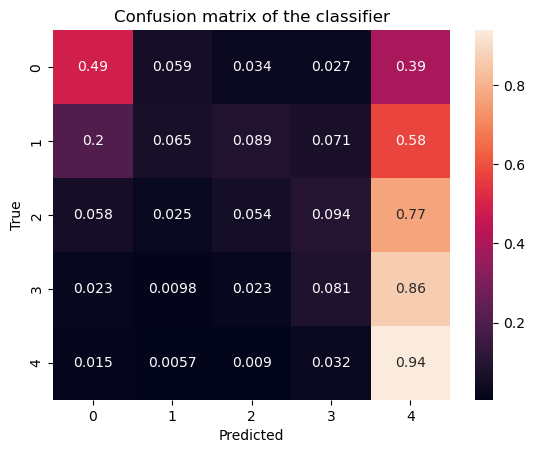

In [8]:
# Evaluate your model on the testing set
Y_test_predictions = model7.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("MSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))
# print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions, squared=False))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [35]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = model7.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

Now you can upload the `submission.csv` to kaggle